# 11-1. 프로젝트: 어떤 예측 모형이 차량 수요 예측에 가장 적합할까?

## import

In [2]:
import os
import requests
from io import BytesIO
from itertools import product
from datetime import datetime

# 데이터 처리
import pandas as pd
import numpy as np

# 시각화
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns

# 분석
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
import statsmodels.api as sm
import pmdarima as pm  

# statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller # 정상성 검정
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings( 'ignore' )

print(pd.__version__)
print(sm.__version__)
print(pm.__version__)

1.2.0
0.12.1
1.8.3


## 차량 수요 예측 데이터 로드 및 Train, Test Data 분류

In [23]:
# 파일 불러오기
file_path_raws = os.getenv('HOME') + '/aiffel/demand_forecasting/data/raws.csv'
df_raws = pd.read_csv(file_path_raws)

# 설명 변수 테이블 설정
_x_data = df_raws[['click_d_1', 'click_d_2', 'click_d_3', 'click_d_4', 'click_d_5', 'click_d_6', 'click_d_7', 'is_clean', 'avg_precipitation', 'avg_temperature', 'target_dates']]

_x_weekday = pd.get_dummies(df_raws['weekday'], prefix='weekday', drop_first=False)

_x_data = pd.concat([_x_data, _x_weekday], axis=1)

_x_data.set_index("target_dates", drop=True, inplace=True)
_x_data = _x_data.sort_values('target_dates')

# 예측 대상 데이터 설정
target = df_raws[['op_rate_0d_all_cars', 'target_dates' ]]

target.set_index("target_dates", drop=True, inplace=True)
target = target.sort_values('target_dates')

# Train/Test 데이터셋 나누기
_x_data_train = _x_data[_x_data.index<'2021-04-01']
_x_data_test = _x_data[_x_data.index>='2021-04-01']
target_train = target[target.index<'2021-04-01']
target_test = target[target.index>='2021-04-01']

x_train = _x_data_train
x_test = _x_data_test
y_train = target_train
y_test = target_test


<class 'pandas.core.frame.DataFrame'>
Index: 52 entries, 2021-04-01 to 2021-05-22
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   click_d_1          52 non-null     int64  
 1   click_d_2          52 non-null     int64  
 2   click_d_3          52 non-null     int64  
 3   click_d_4          52 non-null     int64  
 4   click_d_5          52 non-null     int64  
 5   click_d_6          52 non-null     int64  
 6   click_d_7          52 non-null     int64  
 7   is_clean           52 non-null     int64  
 8   avg_precipitation  52 non-null     float64
 9   avg_temperature    52 non-null     float64
 10  weekday_0          52 non-null     uint8  
 11  weekday_1          52 non-null     uint8  
 12  weekday_2          52 non-null     uint8  
 13  weekday_3          52 non-null     uint8  
 14  weekday_4          52 non-null     uint8  
 15  weekday_5          52 non-null     uint8  
 16  weekday_6       

## Grid search를 이용하여 최상의 파라미터 조합 찾기

동적 회귀 모형을 선언하기 위해서는 (p, d, q) x (P, D, Q)(S) 파라미터를 설정해 주어야 합니다. 이 때 실제로 Grid search를 하여 가장 낮은 AIC를 가지는 파라미터 조합을 선택해요. Grid search는 파라미터가 가질 수 있는 선택지가 많아질수록 탐색 공간이 넓어져 탐색에 오랜 시간이 걸립니다. 예를 들어 모든 파라미터(p, d, q, P, D, Q 총 6가지)를 0과 2 사이(0 또는 1)에서 찾는다면, 탐색 공간은 
2^6 = 64개가 되고 5분 정도 걸려요.

itertools의 product()를 이용하여 최상의 파라미터 조합을 찾아 보세요.

In [14]:
# 모수
p = range(0, 2)
q = range(0, 2)
d = range(0, 2)
P = range(0, 2)
Q = range(0, 2)
D = range(0, 2)

# 초기화
best_AIC = float("inf")
best_model = sm.tsa.SARIMAX(endog=y_train, exog=x_train, order=(0, 0, 0), seasonal_order=(0, 0, 0, 7))
best_values = []
iter_cnt = 0

# for 문으로 최소 AIC 찾기 (Grid Search)

hyper_param = product(p, d, q, P, D, Q)

for param in hyper_param:
    p_value, d_value, q_value, P_value, D_value, Q_value = param
    
    # Fit a SARIMA model
    model = sm.tsa.SARIMAX(endog=y_train, exog=x_train,
                            order=(p_value, d_value, q_value),
                            seasonal_order=(P_value, D_value, Q_value, 7))
    results = model.fit(disp=False)

    # AIC 계산하기
    aic = results.aic

    # Best Model 선정 (AIC 값이 제일 낮은게 Best Model)
    if aic < best_AIC:
        best_AIC = aic
        best_model = model
        best_values =[p_value, d_value, q_value, P_value, D_value, Q_value, 7]
        
    # 예시와 같은 로그 출력하기
    iter_cnt += 1
    print(f'Iter {iter_cnt}/64: SAPIMAX({p_value}, {d_value}, {q_value})x({P_value}, {D_value}, {Q_value})(7), AIC = {aic}')

# Best Model
print('---------------------------------------------------------------')
print(f'Best Iter : SAPIMAX({best_values[0]}, {best_values[1]}, {best_values[2]})x({best_values[3]}, {best_values[4]}, {best_values[5]})(7), AIC = {best_AIC}')

Iter 1/64: SAPIMAX(0, 0, 0)x(0, 0, 0)(7), AIC = 867.3483846700258
Iter 2/64: SAPIMAX(0, 0, 0)x(0, 0, 1)(7), AIC = -2232.0394978926456
Iter 3/64: SAPIMAX(0, 0, 0)x(0, 1, 0)(7), AIC = 1000.9463850813165
Iter 4/64: SAPIMAX(0, 0, 0)x(0, 1, 1)(7), AIC = -2156.50227111441
Iter 5/64: SAPIMAX(0, 0, 0)x(1, 0, 0)(7), AIC = -2244.151968996891
Iter 6/64: SAPIMAX(0, 0, 0)x(1, 0, 1)(7), AIC = -2245.725946960656
Iter 7/64: SAPIMAX(0, 0, 0)x(1, 1, 0)(7), AIC = -2097.2816526313522
Iter 8/64: SAPIMAX(0, 0, 0)x(1, 1, 1)(7), AIC = -2141.838830446514
Iter 9/64: SAPIMAX(0, 0, 1)x(0, 0, 0)(7), AIC = -2326.25584582184
Iter 10/64: SAPIMAX(0, 0, 1)x(0, 0, 1)(7), AIC = -2348.6084755709994
Iter 11/64: SAPIMAX(0, 0, 1)x(0, 1, 0)(7), AIC = -2097.1096732343863
Iter 12/64: SAPIMAX(0, 0, 1)x(0, 1, 1)(7), AIC = -2237.58497479407
Iter 13/64: SAPIMAX(0, 0, 1)x(1, 0, 0)(7), AIC = -2352.47294264588
Iter 14/64: SAPIMAX(0, 0, 1)x(1, 0, 1)(7), AIC = -2354.9173561396033
Iter 15/64: SAPIMAX(0, 0, 1)x(1, 1, 0)(7), AIC = -2183.92

## 모형 구조 확인
model.summary()를 사용해 모형의 정보를 출력

In [5]:
# Best Iter : SAPIMAX(1, 0, 1)x(1, 0, 1)(7)

model = sm.tsa.SARIMAX(endog=y_train, exog=x_train,
                            order=(1, 0, 1),
                            seasonal_order=(1, 0, 1, 7))
result = model.fit(disp=False)
print(result.summary())

                                     SARIMAX Results                                     
Dep. Variable:               op_rate_0d_all_cars   No. Observations:                  571
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood                1205.124
Date:                           Fri, 01 Sep 2023   AIC                          -2366.248
Time:                                   05:20:30   BIC                          -2270.606
Sample:                               09-08-2019   HQIC                         -2328.934
                                    - 03-31-2021                                         
Covariance Type:                             opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
click_d_1          9.342e-06   4.48e-07     20.837      0.000    8.46e-06    1.02e-05
click_d_2         -3.9

## 차량 수요 예측

예측값과 예측값의 신뢰구간을 얻을 수 있는 get_forecast(steps=n)을 사용해 보세요. 학습 데이터 다음부터 지정한 steps만큼 예측할 수 있어요. RMSE와 시각화를 통해 모형의 예측 정확도를 확인해 보세요. RMSE을 구할 때는 예측값에 .predicted_mean을 사용해보세요. 시각화할 때는 이전 스텝에서와 같이 마지막 50개의 데이터만 사용하세요.

In [44]:
# RMSE
forecast = result.get_forecast(steps=52, exog=x_test)
forecast_values = forecast.predicted_mean
rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_test, forecast_values))

print(f'Test RMSE: {rmse: .5f}')

Test RMSE:  0.02264


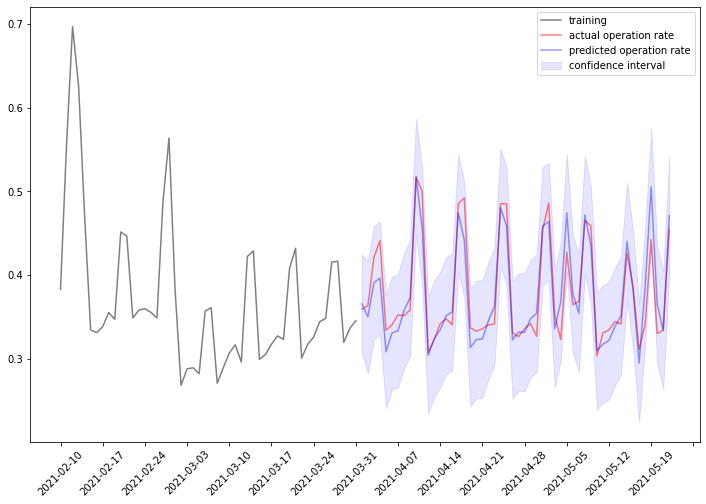

In [63]:
# 시각화
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=7.0) 
ax.xaxis.set_major_locator(loc)
confidence_interval = forecast.conf_int()

plt.plot(y_train[-50:], alpha=0.5, color='black', label='training')
plt.plot(y_test, alpha=0.5, color='red', label='actual operation rate')
plt.plot(y_test.index.values, forecast_values, alpha=0.4, color='blue', label='predicted operation rate')
plt.fill_between(y_test.index.values, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], alpha=0.1, color='b', label='confidence interval')
plt.legend()
plt.show()

## 다른 모형 사용하기

지금까지 배운 모형이 아닌 다른 모형을 사용해 차량 수요 예측을 해보세요. 트리 기반 머신러닝 모형(LGBM, Gradient Boosting, XBG, Random Forest 등)을 사용해 보세요. 3개 이상의 모형을 사용해 차량의 수요를 예측해 보세요.

## 결과 비교

동적 회귀 모형과 여러분들이 사용한 모형들의 예측 정확도를 RMSE를 사용하여 비교해 봅시다. 이전 스텝에서 다루었던 다른 모형들의 예측 정확도를 포함시켜도 좋아요. 어떤 모형이 차량 수요를 가장 잘 예측할까요?

# 회고
---

### 프로젝트 목표

- 데이터의 시계열 패턴에 따라 다양한 시계열 모형(ARIMA 모형, SARIMA 모형 등)을 사용하여 예측 해보기

### 성과 및 결과

- Grid search를 이용하여 파라미터를 찾고 이를 이용하여 RMSE 및 시각화를 진행하였다. 하지만 그외의 다른 모형을 사용하여 차량 수요 예측 모형을 만들어 보는것에 대하여서는 실패하였다..

### 배운 점

- 시계열 데이터를 처음 접하였고 관련 기초가 되는 지식들을 배울 수 있었으며 관련 라이브러리를 사용하여 ARIMA, SARIMA 모형을 만들어 수요 예측모델을 만드는 것을 배울 수 있었다.

### 개선할 점

- 노드에서 배운 이외의 다른 모형에 대하여 적용시키지 못해서 다른 모형에 대한 이해도를 높이고 수요예측이 가능할 수 있도록 학습해야 되겠습니다.

### 결론

- 시계열모형인 ARIMA 모형, SARIMA 모형에 대해서 배우고 이를 가지고 테스트 결과물을 만들어 냈지만 다른 모형을 이용한 수요 예측 모형에 대하여 만들지 못하였다. 이외의 모형들도 학습하여 만들어 볼 수 있도록 해야겠습니다.